In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [27]:
# Load data from _annotations.csv
def load_data(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    bboxes = []

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['filename'])
        img = tf.keras.preprocessing.image.load_img(img_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (224, 224))  # Resize for MobileNetV2
        images.append(img)

        # Normalize bounding box coordinates (to range 0-1)
        bbox = [
            row['xmin'] / row['width'],
            row['ymin'] / row['height'],
            row['xmax'] / row['width'],
            row['ymax'] / row['height'],
        ]
        bboxes.append(bbox)
        labels.append(row['class'])

    return np.array(images), np.array(labels), np.array(bboxes)

# Load train, validation, and test datasets
train_images, train_labels, train_bboxes = load_data('train/_annotations.csv', 'train')
val_images, val_labels, val_bboxes = load_data('valid/_annotations.csv', 'valid')
test_images, test_labels, test_bboxes = load_data('test/_annotations.csv', 'test')

# One-hot encode labels
unique_classes = sorted(set(train_labels))
label_map = {label: idx for idx, label in enumerate(unique_classes)}

train_labels = np.array([label_map[label] for label in train_labels])
val_labels = np.array([label_map[label] for label in val_labels])
test_labels = np.array([label_map[label] for label in test_labels])

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(unique_classes))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(unique_classes))

# Normalize images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [28]:
# Cek urutan kelas yang ada di dalam dataset
print("Unique classes in the dataset:", unique_classes)


Unique classes in the dataset: [np.str_('apel'), np.str_('ayam_bakar'), np.str_('ayam_goreng'), np.str_('brokoli'), np.str_('nasi_kuning'), np.str_('nasi_putih'), np.str_('pisang'), np.str_('semangka'), np.str_('tahu_kuning'), np.str_('tahu_putih'), np.str_('telur_balado'), np.str_('telur_ceplok'), np.str_('telur_dadar'), np.str_('telur_rebus'), np.str_('tempe'), np.str_('timun'), np.str_('tomat')]


In [6]:
# Create the model with transfer learning
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers for classification and bounding box regression
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Classification output
class_output = layers.Dense(len(unique_classes), activation='softmax', name='class_output')(x)

# Bounding box output
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mse',
    },
    metrics={
        'class_output': 'accuracy',
    }
)

# Train the model
history = model.fit(
    train_images, {'class_output': train_labels, 'bbox_output': train_bboxes},
    validation_data=(val_images, {'class_output': val_labels, 'bbox_output': val_bboxes}),
    epochs=10,
    batch_size=32,
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 633ms/step - bbox_output_loss: 0.0694 - class_output_accuracy: 0.4233 - class_output_loss: 1.9507 - loss: 2.0202 - val_bbox_output_loss: 0.0515 - val_class_output_accuracy: 0.7078 - val_class_output_loss: 0.9738 - val_loss: 1.0490
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 58s 590ms/step - bbox_output_loss: 0.0455 - class_output_accuracy: 0.8172 - class_output_loss: 0.6765 - loss: 0.7220 - val_bbox_output_loss: 0.0482 - val_class_output_accuracy: 0.7461 - val_class_output_loss: 0.8133 - val_loss: 0.8854
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 562ms/step - bbox_output_loss: 0.0405 - class_output_accuracy: 0.8429 - class_output_loss: 0.5374 - loss: 0.5779 - val_bbox_output_loss: 0.0480 - val_class_output_accuracy: 0.7509 - val_class_output_loss: 0.7845 - val_loss: 0.8570
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 535ms/step - bbox_output_loss: 0.0387 - class_output_accuracy: 0.8683 - class_output_loss: 0.4344 - loss: 0.4730 - val_bbox_output_loss: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step - bbox_output_loss: 0.0470 - class_output_accuracy: 0.7726 - class_output_loss: 0.7398 - loss: 0.7737
Test Accuracy: 73.38%


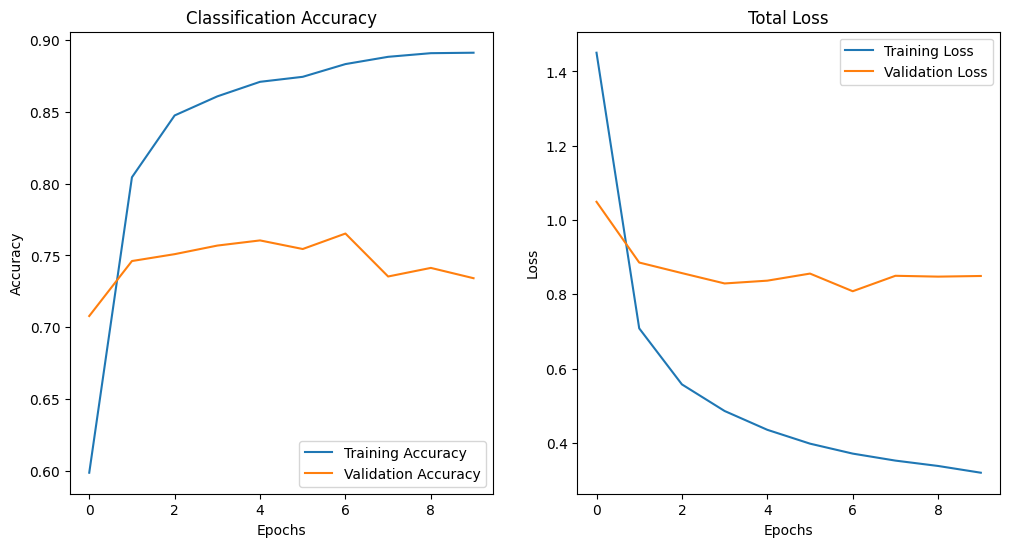

In [9]:
# Pastikan test_labels adalah one-hot encoded
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(unique_classes))

# Evaluasi model
test_loss, test_class_loss, test_bbox_loss, test_class_acc = model.evaluate(
    test_images,
    {'class_output': test_labels, 'bbox_output': test_bboxes}
)
print(f"Test Accuracy: {test_class_acc * 100:.2f}%")

# Plot grafik untuk accuracy dan loss
plt.figure(figsize=(12, 6))

# Grafik Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


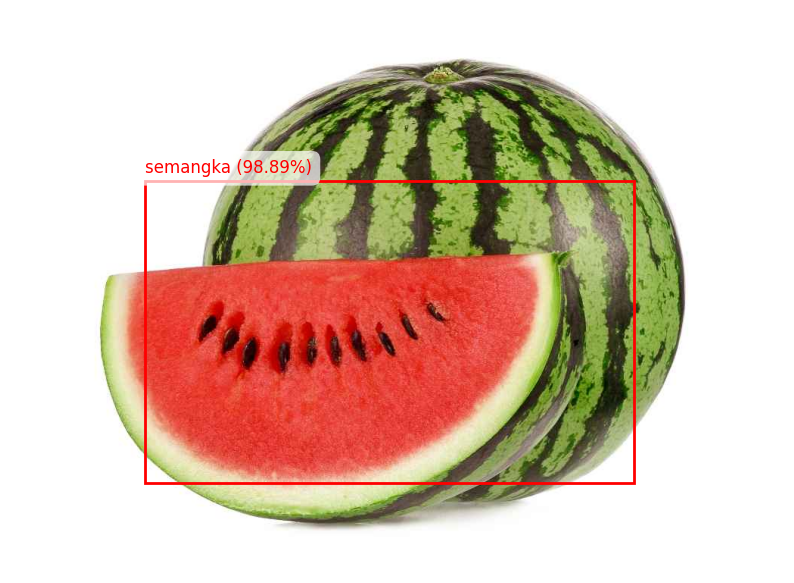

Predicted class: semangka
Prediction probability: 98.89%


In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(224, 224)):
    # Memuat gambar dan mengubahnya menjadi array
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    
    # Normalisasi gambar (0-255 menjadi 0-1)
    img_array = img_array / 255.0
    
    # Tambahkan batch dimension (dari (224, 224, 3) menjadi (1, 224, 224, 3))
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_and_show_result(img_path, model, label_map):
    # Pra-pemrosesan gambar
    img_array = preprocess_image(img_path)
    
    # Lakukan prediksi
    class_pred, bbox_pred = model.predict(img_array)
    
    # Ambil hasil prediksi kelas (kemungkinan terbesar)
    class_idx = np.argmax(class_pred)
    class_name = label_map[class_idx]
    
    # Ambil koordinat bounding box prediksi
    xmin, ymin, xmax, ymax = bbox_pred[0]
    
    # Muat gambar asli untuk menampilkan bounding box
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    
    # Plot gambar dengan bounding box
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img / 255.0)  # Gambar sudah dalam rentang [0, 1]
    
    # Gambar bounding box
    rect = patches.Rectangle(
        (xmin * img.shape[1], ymin * img.shape[0]),
        (xmax - xmin) * img.shape[1],
        (ymax - ymin) * img.shape[0],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    
    # Menambahkan label kelas dan probabilitas ke gambar
    plt.text(
        xmin * img.shape[1], ymin * img.shape[0] - 10,
        f"{class_name} ({class_pred[0][class_idx]*100:.2f}%)",
        color='red',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
    )
    
    # Tampilkan gambar dengan bounding box
    plt.axis('off')
    plt.show()

    # Menampilkan class prediction beserta probablity
    print(f"Predicted class: {class_name}")
    print(f"Prediction probability: {class_pred[0][class_idx]*100:.2f}%")

# Misalnya, jika Anda ingin melakukan prediksi pada gambar test:
img_path = './tessemangka.png'  # Ganti dengan path gambar yang ingin diprediksi

# Gantilah `label_map` dengan mapping label dari model yang Anda gunakan
label_map = {
    0: 'apel', 
    1: 'ayam_bakar', 
    2: 'ayam_goreng', 
    3: 'brokoli', 
    4: 'nasi_kuning', 
    5: 'nasi_putih',
    6: 'pisang', 
    7: 'semangka', 
    8: 'tahu_kuning', 
    9: 'tahu_putih', 
    10: 'telur_balado', 
    11: 'telur_celpok',
    12: 'telur_dadar', 
    13: 'telur_rebus', 
    14: 'tempe', 
    15: 'timun', 
    16: 'tomat'
}

predict_and_show_result(img_path, model, label_map)
